In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

import math

import mne # See docs: https://mne.tools/dev/generated/mne.io.read_raw_edf.html
import pyedflib # See docs: https://pyedflib.readthedocs.io/en/latest/
from pyedflib import highlevel

In [ ]:
eva_01 = ["#995cd0", "#8edf5f", "#ec7744", "#5549b7", "#201d30"]; 
eva_01_light = ["#c7fba5", "#adf182", "#916cad", "#523874", "#dc7d68"]

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [ ]:
# Defining the file path as a string for easier use
file_path = '/Users/jacksonpowell/Documents/GitHub/learningML/data_files/sub-01_ses-01_task-musicTherapy_eeg.edf'; 

In [ ]:
# "highlevel" takes data from .edf file (see docs in includes) and saves in signals (np.array of numbers) and headers (dicts)
signals, signal_headers, data_header = highlevel.read_edf(file_path); 

# Printing to see data and size
print(signal_headers[0]);  
print(signals[0].shape); 

In [97]:
def plot_signal(signal, header, window, color = None, tag = None):

    if not tag: 
        tag = ""; 

    frequency = header["sample_frequency"]; # Takes frequency value from header dict

    total_time_seconds = len(signal) / frequency; # Storing total time in seconds
    total_time_mins = len(signal) / frequency / 60; # Storing total time in minutes 
    time = np.linspace(0, total_time_seconds, len(signal), endpoint=True); # Creating x-axis based on frequency

    start_time = window[0]; # Taking first value in window array, aka the start of the zoomed frame
    stop_time = window[1]; # Taking second value in window array, aka the end of the zoomed frame

    time_frame = stop_time - start_time; # Total time of zoomed frame
    zoomed_frame = int(time_frame * frequency); # Number of data points in zoomed frame
    zoomed_signal = signal[int(start_time * frequency) : int(stop_time * frequency)]; # Subset of signal plotted
    zoomed_time = np.linspace(start_time, stop_time, zoomed_frame, endpoint=True); # x-axis for zoomed plot

    # Plot specificiations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4)); 

    ax1.plot(time, signal, color = color, linewidth = 0.3); 
    ax1.set_xlabel('time (s)'); 
    ax1.set_ylabel('voltage (uV)'); 
    ax1.set_title(f"total frame, {tag} {header['label']}"); 
    ax1.set_facecolor(eva_01_light[0])

    ax2.plot(zoomed_time, zoomed_signal, color = color, linewidth = 0.3); 
    ax2.set_xlabel('time (s)'); 
    ax2.set_ylabel('voltage (uV)'); 
    ax2.set_title(f"from {start_time}s to {stop_time}s, {tag} {header['label']}"); 
    ax2.set_facecolor(eva_01_light[0])

    plt.show(); 

In [ ]:
start_time = 100; 
stop_time = 110; 

for i in range(0, len(signal_headers), 1): # Plotting over all electrodes
    # Information is the signal to be plotted, its corresponding header, and then a zoomed in window
    # I.e., if you want to see a zoomed in plot from seconds 0 to 5, the third argument would be [0,5]
    plot_signal(signals[i], signal_headers[i], [start_time, stop_time]); 

In [ ]:
def plot_all_signal(all_signals, all_headers, tag = None): 

    figure_length = len(all_signals); # In inches (scaling based on # of electrodes)
    plt.figure(figsize = (figure_length, 7)); 

    for i in range(0, len(all_signals), 1): # Plotting over all electrodes
        # Information is the signal to be plotted, its corresponding header, and then a zoomed in window
        # I.e., if you want to see a zoomed in plot from seconds 0 to 5, the third argument would be [0,5] 

        if not tag: 
            tag = ""; 

        frequency = all_headers[i]["sample_frequency"]; # Takes frequency value from header dict

        total_time_seconds = len(all_signals[i]) / frequency; # Storing total time in seconds
        total_time_mins = len(all_signals[i]) / frequency / 60; # Storing total time in minutes 
        time = np.linspace(0, total_time_seconds, len(signals[0]), endpoint=True); # Creating x-axis based on frequency

        # Plot specificiations
        len(all_signals)

        plt.tight_layout(h_pad = 2)
        ax = plt.subplot(4, 2, i + 1)
        
        ax.plot(time, all_signals[i], linewidth = 0.3, color = eva_01_light[i % len(eva_01)]); 
        ax.set_xlabel('time (s)', fontsize = 8); 
        ax.set_ylabel('voltage (uV)', fontsize = 8); 
        ax.set_title(f"{tag} {all_headers[i]['label']}", fontsize = 10); 
        plt.xticks(fontsize=8); 
        plt.yticks(fontsize=8); 

In [ ]:
plot_all_signal(signals, signal_headers)

In [ ]:
from scipy import signal

In [ ]:
signal_num = 5; # Which signal we want to filter

# A zoomed in timeframe, if we want to look closely at a segment of the wave form
start_time = 625; 
stop_time = 635; 

# Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
# Bandpass filter with delta F freq values contained in [f1,f2]---functions as corner frequencies, like in electronics
bandpass = signal.butter(1, [2, 5], 'bandpass', fs=1024, output='sos'); 
filtered_signal = signal.sosfilt(bandpass, signals[signal_num]); 

# Plotting to compare filtered and unfiltered data
plot_signal(filtered_signal, signal_headers[signal_num], [start_time, stop_time], 'darkgreen', tag = "filtered"); 
plot_signal(signals[signal_num], signal_headers[signal_num], [start_time, stop_time]); 

In [ ]:
filtered_signals = np.zeros((len(signals), len(signals[0]))); 

bandpass = signal.butter(1, [2, 5], 'bandpass', fs=1024, output='sos'); 

for i in range(0, len(signals), 1):
    filtered_signals[i] = signal.sosfilt(bandpass, signals[i]); 

# Plotting to compare filtered and unfiltered data
plot_all_signal(filtered_signals, signal_headers)

In [ ]:
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skew, kurtosis

In [ ]:
# Docs: https://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn.feature_extraction import DictVectorizer

In [ ]:
# Features to add that are pre-built: 
    #   Docs: https://docs.scipy.org/doc/scipy/reference/stats.html
    #   Entropy, differential entropy
    #   Trimmed statistics
    #   Median absolute deviation
    #   Cumulative and relative frequency

# Features to add by user: 
    #   Spikes, polyspikes---value and number
    #   Spike and wave
    #   Sharp wave complexes
    #   Slow cortical potentials
    #   Sensorimotor rhythms
    #   P300 event-related potential
    #   Steady-state visual evoked potentials
    #   Error-related negative evoked potentials

def extract_allFeatures(all_signals, all_headers):

    figure_length = len(all_signals); # In inches (scaling based on # of electrodes)
    plt.figure(figsize = (figure_length, 7)); 

    features_matrix = np.zeros((len(signals), 6)) # Initializing 2D, x by 1 array
    vec = DictVectorizer(); 

    # The list of features, in a dictionary, that we will extract
    for i in range(0, len(all_signals), 1):

        local_features_dict = {
                    'label' : all_headers[i]['label'], 
                    'mean' : 0, 
                    'std_dev': 0,
                    'skewness' : 0,
                    'kurt' : 0, 
                    'dominant_freq' : 0
                    }

        # Populating the features dictionary 
        local_features_dict['mean'] = np.mean(all_signals[i]); 

        std_dev = np.std(all_signals[i]); 
        local_features_dict['std_dev'] = std_dev; 

        local_features_dict['skewness'] = skew(all_signals[i]); 
        local_features_dict['kurt'] = kurtosis(all_signals[i]); 

        # Normalizing the signal before fft processing
        normalized_signal = (all_signals[i] - np.mean(all_signals[i])) / np.std(all_signals[i])

        # The total number and time between data points
        N = len(all_signals[i]); 
        delta_t = 1 / all_headers[i]['sample_frequency']; 


        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # User defined features  
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        j = 0; # Used to index through the array
        num_spikes = 0; # Will store the number of spikes in this segment 
        while j < len(all_signals[i]):
            if all_signals[i][j] > 3 * std_dev: # Begins counting when an amplitude that's 3 std dev above the mean is found
                start_pos = j; # Saves the starting time (of high amplitude)
                while all_signals[i][j] > 3 * std_dev and not j == len(all_signals[i]) - 1: # Added second condition because it would break when reaching the end of the list
                    j += 1; 
                stop_pos = j; # Stores the ending time (of high amplitude)
        
                duration = (stop_pos - start_pos) * delta_t; # Computes the duration of the high amplitude (in seconds)
                if duration > 0.05: # 50 ms currently 
                    num_spikes += 1; # Counts the number of spikes that persist for more than x ms 
            j += 1; # Continues on through the list
        
        print(f"{all_headers[i]['label']} had {num_spikes}"); 

        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # FFT  
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        # Running fft and solving for the frequency domain (x axis)
        fft_values = fft(normalized_signal); 
        freq_domain = np.fft.fftfreq(N, d = delta_t); 
        fft_magnitude = np.abs(fft_values); 
        
        # Dominant frequency found as the highest magnitude fft value and its corresponding location in the frequency domain
        local_features_dict['dominant_freq'] = freq_domain[np.argmax(fft_magnitude)]; 
        
        features_vec = vec.fit_transform(local_features_dict).toarray(); 
        vec.get_feature_names_out()

        features_matrix[i] = features_vec; 


        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # Plotting 
        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        plt.tight_layout(h_pad = 2)
        ax = plt.subplot(4, 2, i + 1)
        
        # I don't really understand what // does but every online resource uses this 
        ax.plot(freq_domain[:N//2], abs(fft_values[0:N//2]), linewidth = 0.5, color = eva_01[i % len(eva_01)]); 
        ax.set_xlabel('freq (hz)', fontsize = 8); 
        ax.set_title(f"{local_features_dict['label']}, dom_freq = {round(local_features_dict['dominant_freq'], 2)} hz", fontsize = 10); 
        plt.xticks(fontsize = 8); 
        plt.yticks(fontsize = 8); 

    return features_matrix; 

In [ ]:
# Build features matrix

features = extract_allFeatures(signals, signal_headers); 


In [ ]:
# Features to add that are pre-built: 
    #   Docs: https://docs.scipy.org/doc/scipy/reference/stats.html
    #   Entropy, differential entropy
    #   Trimmed statistics
    #   Median absolute deviation
    #   Cumulative and relative frequency

# Features to add by user: 
    #   Spikes, polyspikes---value and number
    #   Spike and wave
    #   Sharp wave complexes
    #   Slow cortical potentials
    #   Sensorimotor rhythms
    #   P300 event-related potential
    #   Steady-state visual evoked potentials
    #   Error-related negative evoked potentials

def extractFeatures(signal, header):

    # This is used to convert the dictionary to a vector
    # Notably, there seems to be an issue where dictionary order is not preserved, which 
    # can be a bit inconvenient and confusing when trying to test data. It may be wise to
    # abandon dictionaries and store simply as vectors---which is a bit less easy to read,
    # but may prevent issues later. 
    vec = DictVectorizer(); 

    # The list of features, in a dictionary, that we will extract

    local_features_dict = {'label' : header['label'], 
                'mean' : 0, 
                'std_dev': 0,
                'skewness' : 0,
                'kurt' : 0, 
                'dominant_freq' : 0}

    # Populating the features dictionary 
    local_features_dict['mean'] = np.mean(signal); 

    std_dev = np.std(signal); 
    local_features_dict['std_dev'] = std_dev; 

    local_features_dict['skewness'] = skew(signal); 
    local_features_dict['kurt'] = kurtosis(signal); 

    # Normalizing the signal before fft processing
    normalized_signal = (signal - np.mean(signal)) / np.std(signal)

    # The total number and time between data points
    N = len(signal); 
    delta_t = 1 / header['sample_frequency']; 


    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # User defined features  
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # NOTE: A wiser way to do this would be to take the derivative, and calculate the period when the 
    # derivative is greater than x for duration y (to mark the start time), etc. Right now we define 
    # the start time by magnitude, which is technically not the beginning of the spike. Plus, it might
    # be helpful for noiser data (i.e., right now we define by std dev above the mean, which may vary
    # depending on how noisy the data is). 

    j = 0; # Used to index through the array
    num_spikes = 0; # Will store the number of spikes in this segment 
    while j < len(signal):
        if signal[j] > 3 * std_dev: # Begins counting when an amplitude that's 3 std dev above the mean is found
            start_pos = j; # Saves the starting time (of high amplitude)
            while signal[j] > 3 * std_dev and not j == len(signal) - 1: # Added second condition because it would break when reaching the end of the list
                j += 1; 
            stop_pos = j; # Stores the ending time (of high amplitude)
    
            duration = (stop_pos - start_pos) * delta_t; # Computes the duration of the high amplitude (in seconds)
            if duration > 0.05: # 50 ms currently 
                num_spikes += 1; # Counts the number of spikes that persist for more than x ms 
        j += 1; # Continues on through the list
    

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # FFT  
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # Running fft and solving for the frequency domain (x axis)
    fft_values = fft(normalized_signal); 
    freq_domain = np.fft.fftfreq(N, d = delta_t); 
    fft_magnitude = np.abs(fft_values); 
    
    # Dominant frequency found as the highest magnitude fft value and its corresponding location in the frequency domain
    local_features_dict['dominant_freq'] = freq_domain[np.argmax(fft_magnitude)]; 
    
    features_vec = vec.fit_transform(local_features_dict).toarray(); 
    vec.get_feature_names_out()

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Plotting 
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


    return features_vec, local_features_dict; 

In [139]:
window_features, window_dictionary = extractFeatures(signals[0], signal_headers[0]);

print(window_dictionary)
print(window_features)

{'label': 'Fp1', 'mean': 14350207.314645413, 'std_dev': 5050612.777719861, 'skewness': -0.15062924055470017, 'kurt': -0.5356172739824374, 'dominant_freq': 60.018573551262996}
[[ 6.00185736e+01 -5.35617274e-01  1.00000000e+00  1.43502073e+07
  -1.50629241e-01  5.05061278e+06]]


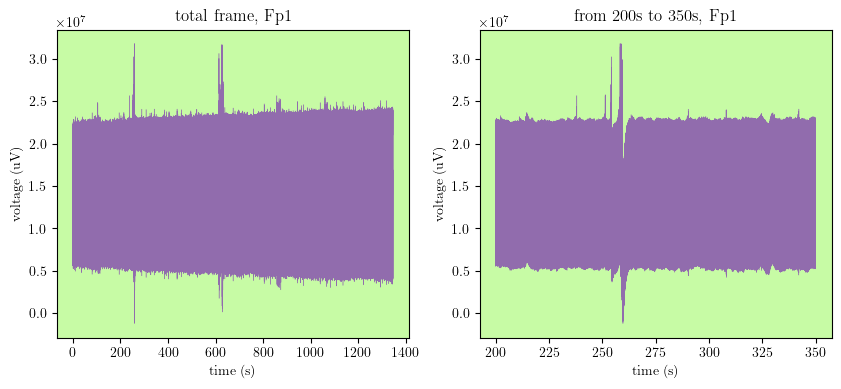

(898, 6)
(898,) (898,)


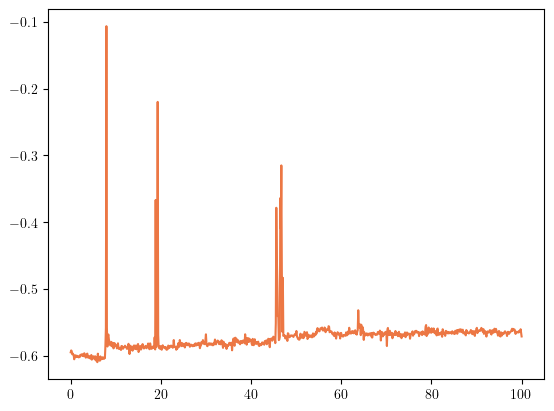

In [137]:
scan_duration = 1.500; # Define rolling scanner duration in s
scan_overlap = 0.500; # Define overlap between windows in s

frequency = signal_headers[0]["sample_frequency"]; 

scan_duration_indexes = int(scan_duration * frequency); # Converts the duration to indices
scan_overlap_indexes = int(scan_overlap * frequency); # Converts the overlap to indices

plot_signal(signals[0], signal_headers[0], [200, 350], color = eva_01_light[2]); # Temporary plotting just to test

signal = signals[0]; # The signal we will analyze (should optimize this bit later)
header = signal_headers[0]; # The corresponding header
total_window_count = math.ceil(len(signal) / (scan_duration_indexes - scan_overlap)); # The number of windows we will analyze (height of features matrix)

features_matrix = np.zeros((total_window_count,6)) # NOTE: need to replace with the number of features later

scan_start = 0; # The starting index for each individual window
window_counter = 0; # Will use this to index through features matrix
while scan_start < len(signal): 

    if scan_start + scan_duration_indexes < len(signal): # Extracts width of window 
        temp_window = signal[scan_start:scan_start + scan_duration_indexes]; 
    else: # Extracts from start to end in the event that we are close to end of the total time and cannot fit in a full window
        # It's not clear to me if this is good to do, or if we should drop this data point---i.e., it may provide odd values if weighted equally
        temp_window = signal[scan_start:]; 
    
    window_features, window_dictionary = extractFeatures(temp_window, header); 
    features_matrix[window_counter] = window_features; # Adding vector to features matrix

    scan_start += int(scan_duration_indexes - scan_overlap); # Setting the new start time for the next window
    window_counter += 1; # Indexing up for our counter 

print(features_matrix.shape)

# %%%%%%%%%%%%%%%%%%%%%%%%
# Plotting
# %%%%%%%%%%%%%%%%%%%%%%%%

mean_over_windows = features_matrix[:,1]
x = np.linspace(0, 100, len(features_matrix))
print(x.shape, mean_over_windows.shape)

plt.plot(x, mean_over_windows, color = eva_01[2])